<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Autoencoder%20Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Benchmark

## Import dependencies for Google Colab

In [1]:
! git clone https://github.com/nahumsa/DM-Reconstruction

Cloning into 'DM-Reconstruction'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 254 (delta 48), reused 8 (delta 1), pack-reused 156
Receiving objects: 100% (254/254), 2.80 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 3.4MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for qutip: filename=qutip-4.5.2-cp36-cp36m-linux_x86_64.whl size=12575492 sha256=44684cbdb4812a22c944d701b3b117146aabe2eda77ee7d3931f394a4866a670
  Stored in directory: /root/.cache/pip/wheels/ae/90/e9/f26fdecfb6c0e9d9d6f5fa564d16d26ff2bdfd8ad6e7a8a28a
Successfully built qutip


In [3]:
% cd DM-Reconstruction/

/content/DM-Reconstruction


## Import Dependencies

In [4]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

import numpy as np
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [5]:
%load_ext autoreload
%autoreload 2

## Loading Dataset

In [6]:
X_train = np.loadtxt('Data/Measurements/X_train.txt')
X_test = np.loadtxt('Data/Measurements/X_test.txt')

# Model

## 1) Using a simple AutoEncoder with a Mean Squared Error

In [7]:
from Models.AE import AutoEncoder
latent_dim = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

AE = AutoEncoder(original_dim=input_dim, 
            intermediate_dim= hidden_dims,
            latent_dim=latent_dim,
            dropout_rate=dropout_rate)

AE.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
epochs = 10
history = AE.fit(x=X_train,
                 y=X_train, 
                 epochs=epochs,                                                                                   
                 validation_data=(X_test,X_test)
                )

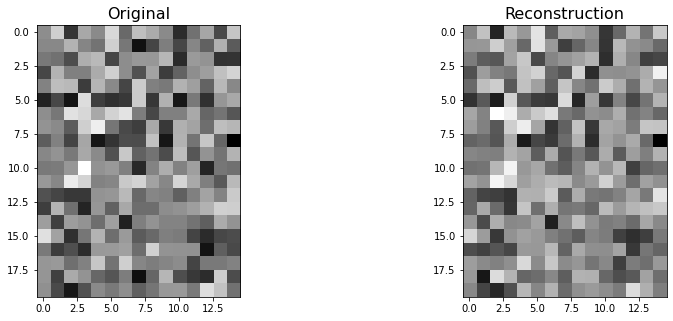

In [9]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_test[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(AE.predict(X_test[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

plt.show()

In [10]:
from Utils.QMetrics import fidelity_rho

fid = []

with tqdm(total=len(X_test)) as pbar:
  for val_1, val_2 in zip(X_test, AE.predict(X_test)):
    fid.append(fidelity_rho(val_1,val_2))
    pbar.update(1)

print(f'Fidelity: {np.mean(fid)}')


Fidelity: 0.9581938973853666


## 2) Using a AutoEncoder with trace distance as a loss function

In [11]:
from tensorflow.keras import layers
import tensorflow as tf
import numpy as numpy

class Encoder(layers.Layer):
    """Maps Input to latent dimension."""

    def __init__(self,
                latent_dim,
                intermediate_dim,
                dropout_rate,
                **kwargs):
      
      super(Encoder, self).__init__(**kwargs)
      self.dense_proj = []
      for i in intermediate_dim:        
        self.dense_proj.append(layers.Dense(i,
                                            activation=tf.nn.relu))
      
      self.dropout_rate = dropout_rate
      
      if self.dropout_rate:
        self.dropout = layers.Dropout(self.dropout_rate)

      self.latent_layer = layers.Dense(latent_dim)    

    def call(self, inputs):
      x = self.dense_proj[0](inputs)
      
      for lay in self.dense_proj[1:]:
        x = lay(x)
        if self.dropout_rate:
          x = self.dropout(x)
          
      return self.latent_layer(x)

class Decoder(layers.Layer):
  """Decodes the encoded representation of the Encoder."""

  def __init__(self,
               original_dim,
               intermediate_dim,
               dropout_rate=None,
               **kwargs):
    super(Decoder, self).__init__(**kwargs)

    self.dense_proj = []
    for i in reversed(intermediate_dim):      
      self.dense_proj.append(layers.Dense(i,
                                          activation=tf.nn.relu))
    
    self.dropout_rate = dropout_rate
    
    if self.dropout_rate:
      self.dropout = layers.Dropout(self.dropout_rate)

    self.dense_output = layers.Dense(original_dim)

  def call(self, inputs):
    x = self.dense_proj[0](inputs)
    
    for lay in self.dense_proj[1:]:
      x = lay(x)
      if self.dropout_rate:
        x = self.dropout(x)

    return self.dense_output(x)

In [26]:
from Utils.QMetrics import trace_loss, fidelity_rho
class TraceAutoEncoder(tf.keras.Model):
  """ AutoEncoder Model.

  Parameters
  -----------------------------------
  original_dim(int): Dimension of the input.
  intermediate_dim(list): Number of neurons on intermediate layers.
  latent_dim(int): Latent dimension.
  dropout_rate(float): Percentage of dropout.

  """

  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,
               dropout_rate,       
               **kwargs):
    super(TraceAutoEncoder, self).__init__()    
    self.encoder = Encoder(latent_dim=latent_dim, 
                           dropout_rate=dropout_rate,
                           intermediate_dim= intermediate_dim)
    self.decoder = Decoder(original_dim, 
                           dropout_rate= dropout_rate,
                           intermediate_dim= intermediate_dim)    
    self.fidelity = []
  
  def call(self, inputs):
    z = self.encoder(inputs)
    reconstructed = self.decoder(z)    
    return reconstructed

  def training_step(self, data, r_loss):
    """Training step for the AE.
  
    Parameters
    -------------------------------------------
    x: Data    
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.    

    Return:
    Loss(float): Loss value of the training step.

    """
    x, y = data

    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      
      # Compute loss.
      loss = trace_loss(y, reconstructed)            
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))    
    
    fid = []
    for val_1, val_2 in zip(y.numpy(), reconstructed.numpy()):
      fid.append(fidelity_rho(val_1,val_2))    

    return loss, np.mean(fid)

  def validating_step(self, data, r_loss):
    """Validation step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data    
    r_loss(float): Parameter controlling reconstruction loss.    

    Return:
    Loss(float): Loss value of the training step.

    """
    x,y = data

    reconstructed = self(x)  # Compute input reconstruction.
    # Compute loss.
    loss = trace_loss(y, reconstructed)    
    
    fid = []
    for val_1, val_2 in zip(y.numpy(), reconstructed.numpy()):
      fid.append(fidelity_rho(val_1,val_2))    

    return loss, np.mean(fid)

  def training(self, dataset, 
             epochs, r_loss,              
             test= None ,Plotter=None):
    """ Training of the Variational Autoencoder for a 
    tensorflow.dataset.

    Parameters
    -------------------------------------------
    dataset(tf.data.Dataset): Dataset of the data.    
    epochs(int): Number of epochs.
    r_loss(float): Parameter controlling reconstruction loss.    
    Plotter(object): Plotter object to show how the training is
                    going (Default=None).

    """

    losses = []
    val_losses = []
    fidelities = []
    val_fidelities = []
    epochs = range(epochs)

    for i in tqdm(epochs, desc='Epochs'):
      losses_epochs = []
      fidelity_epochs =[]
      for step, x in enumerate(dataset):

        loss, fidelity = self.training_step(x, r_loss)
  
        # Logging.
        losses_epochs.append(float(loss))
        fidelity_epochs.append(float(fidelity))
      
      losses.append(np.mean(losses_epochs))
      fidelities.append(np.mean(fidelity_epochs))
      
      if test:
        val_losses_epochs = []
        val_fidelity_epochs = []

        for step, x in enumerate(test):

          val_loss, val_fidelity = self.validating_step(x, r_loss)
    
          # Logging.
          val_losses_epochs.append(float(val_loss))
          val_fidelity_epochs.append(float(val_fidelity))
        
        val_losses.append(np.mean(val_losses_epochs))
        val_fidelities.append(np.mean(val_fidelity_epochs))

      if Plotter != None:
        if test:
          Plotter.plot([losses,val_losses])          
        else:
          Plotter.plot(losses)
        

    return losses, val_losses, fidelities, val_fidelities

In [27]:
from Models.AE import AutoEncoder
latent_dim = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

AE = TraceAutoEncoder(original_dim=input_dim, 
            intermediate_dim= hidden_dims,
            latent_dim=latent_dim,
            dropout_rate=dropout_rate)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
AE.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, X_test))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batchsize)

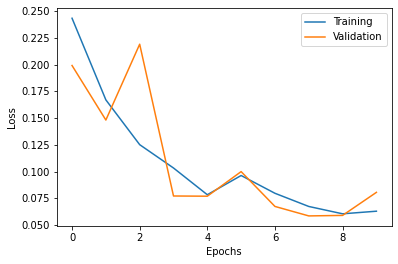

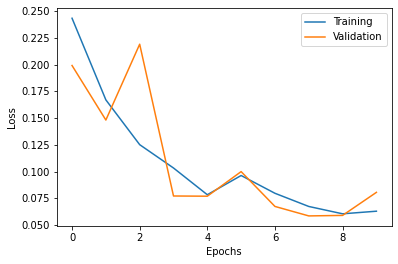

In [28]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
epochs = 10

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs, val_loss_epochs, fidelity_epochs, val_fidelity_epochs = AE.training(dataset, 
                                                                                  epochs, 
                                                                                  r_loss,                                                                                   
                                                                                  test=val_dataset, 
                                                                                  Plotter=plotter)

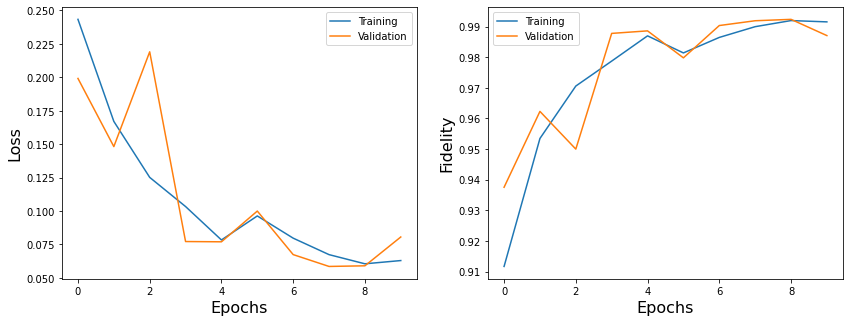

In [29]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Fidelity', size=16)
ax2.legend()
plt.show()

In [31]:
# Saving results
np.savetxt('Results/TAE/TAE_Fidelity.txt', fidelity_epochs)
np.savetxt('Results/TAE/TAE_Loss.txt', loss_epochs)